## Face recognition

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.python.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,ZeroPadding2D,Dropout,Softmax
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python.keras import Sequential
from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import fetch_lfw_pairs
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import cv2
!pip install scikit-plot
import scikitplot as skplt
import numpy as np
import random
import pandas as pd

# Commented out IPython magic to ensure Python compatibility.
import tensorflow_datasets as tfds
import tensorflow as tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Prepare Training

El dataset contiene imágenes de 19 personas, no obstante para cada una de ellas hay un número de imágenes diferente. Se escogen solo las personas que tengan 100 imágenes o más.

In [2]:
# For GOOGLE COLAB
# ==========
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
data_dir = "/content/drive/MyDrive/Colab Notebooks/scikit_learn_data2"

Mounted at /content/drive


In [4]:
# For OS
# ==========

"""
import os
d = os.path.dirname(os.getcwd())
data_zip_dir = os.path.join(d, "data/model_4/scikit_learn_data.zip")
import zipfile
with zipfile.ZipFile(data_zip_dir, 'r') as zip_ref:
   zip_ref.extractall(os.path.join(d, "data/model_4"))

data_dir = os.path.join(d, "data/model_4/scikit_learn_data2")
"""

'\nimport os\nd = os.path.dirname(os.getcwd())\ndata_zip_dir = os.path.join(d, "data/model_4/scikit_learn_data.zip")\nimport zipfile\nwith zipfile.ZipFile(data_zip_dir, \'r\') as zip_ref:\n   zip_ref.extractall(os.path.join(d, "data/model_4"))\n\ndata_dir = os.path.join(d, "data/model_4/scikit_learn_data2")\n'

In [3]:
#data = fetch_lfw_people(data_home = data_dir, resize=1.0, color=True)
data = fetch_lfw_people(data_home = data_dir, min_faces_per_person = 100, resize = 1.0, slice_ = (slice(30, 220), slice(30, 220)), color = True, funneled = True)

class_count = len(data.target_names)

<Axes: >

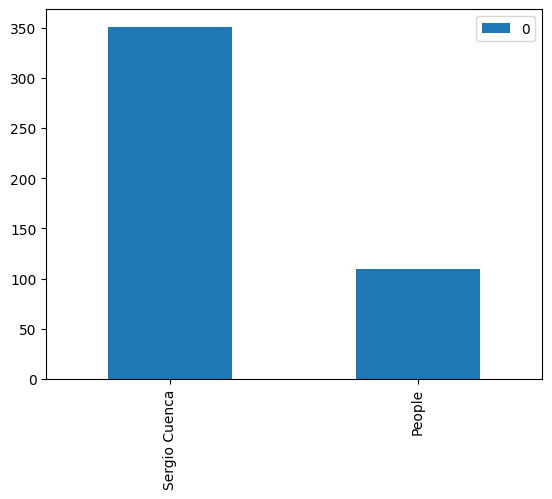

In [5]:
from collections import Counter
counts = Counter(data.target)
names = {}

for key in counts.keys():
    names[data.target_names[key]] = counts[key]

df = pd.DataFrame.from_dict(names, orient='index')
df.plot(kind='bar')

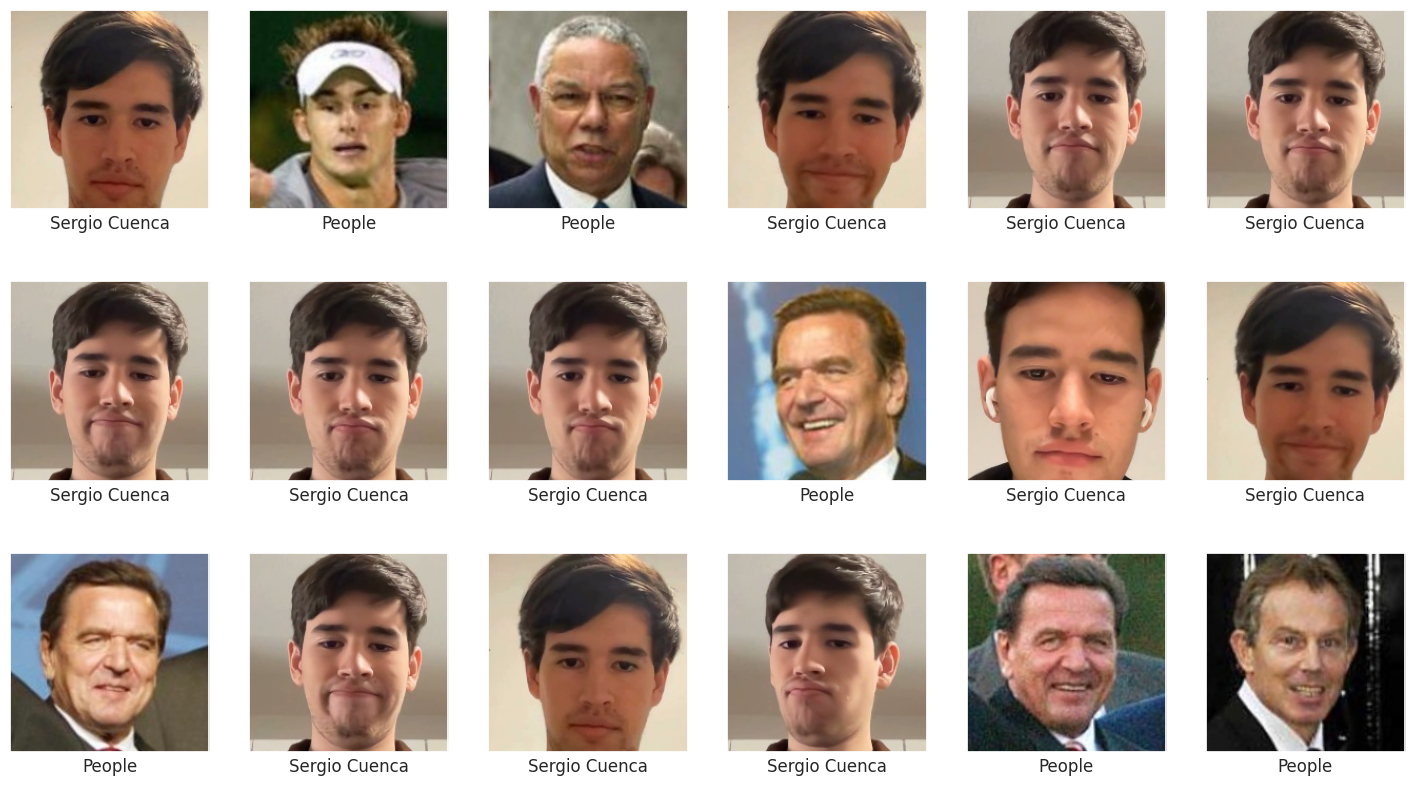

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, ax = plt.subplots(3, 6, figsize=(18, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(data.images[i] / 255) # Scale pixel values so Matplotlib doesn't clip everything above 1.0
    axi.set(xticks=[], yticks=[], xlabel=data.target_names[data.target[i]])

## Balancing the data

Los modelos de clasificación se entrenan mejor con datasets que estén balanceados. Es por ello que se utilizan 100 imágenes para cada persona.

In [7]:
mask = np.zeros(data.target.shape, dtype=np.bool_)

for target in np.unique(data.target):
    mask[np.where(data.target == target)[0][:100]] = 1

x_faces = data.data[mask]
y_faces = data.target[mask]
x_faces = np.reshape(x_faces, (x_faces.shape[0], data.images.shape[1], data.images.shape[2], data.images.shape[3]))
x_faces.shape

(200, 190, 190, 3)

In [8]:
####### Train and test splitting of data #######

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split

face_images = preprocess_input(np.array(x_faces))
face_labels = to_categorical(y_faces)

# In the first step we will split the data in training and remaining dataset
x_train, x_rem, y_train, y_rem = train_test_split(face_images, face_labels, train_size = 0.8, stratify = face_labels, random_state = 0)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# Define valid_size=0.5 (that is 50% of remaining data)
x_valid, x_test, y_valid, y_test = train_test_split(x_rem, y_rem, test_size = 0.5, stratify = y_rem, random_state = 0)

#x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, train_size=0.8, stratify=face_labels, random_state=0)

## Use transfer learning with ResNet50 and ImageNet weights

El primer modelo emplea transfer learning con ResNet50 con pesos calculados de una red entranada con más de 1 millón de imágenes del dataset de ImageNet. Se empieza por cargar ResNet50 sin las capas de clasificación y congelando las capas del cuello de botella

In [9]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [10]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Resizing

model = Sequential()
model.add(Resizing(224, 224))
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(class_count, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['categorical_accuracy'])

In [11]:
import time

start_time = time.time()
hist = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=10, epochs=10)
end_time = time.time()

print("###### Total Time Taken: ", round((end_time - start_time)/60), 'Minutes ######')

Epoch 1/10
16/16 [==============================] - 72s 4s/step - loss: 12.4984 - categorical_accuracy: 0.9312 - val_loss: 3.9899e-21 - val_categorical_accuracy: 1.0000
Epoch 2/10
16/16 [==============================] - 82s 5s/step - loss: 0.0833 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 3/10
16/16 [==============================] - 95s 6s/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 4/10
16/16 [==============================] - 60s 4s/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 5/10
16/16 [==============================] - 58s 4s/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 6/10
16/16 [==============================] - 60s 4s/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_cate

[]

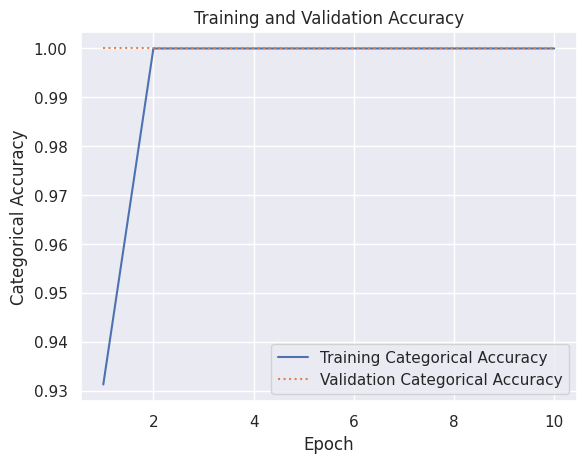

In [13]:
acc = hist.history['categorical_accuracy']
val_acc = hist.history['val_categorical_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training Categorical Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Categorical Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')
plt.legend(loc='lower right')
plt.plot()

1/1 [==============================] - 13s 13s/step


Text(109.44999999999997, 0.5, 'Actual label')

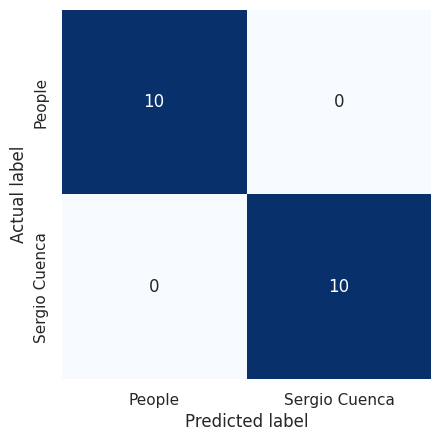

In [14]:
y_predicted = model.predict(x_valid)
mat = confusion_matrix(y_valid.argmax(axis=1), y_predicted.argmax(axis=1))
 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = data.target_names, yticklabels = data.target_names)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

1/1 [==============================] - 4s 4s/step


Text(109.44999999999997, 0.5, 'Actual label')

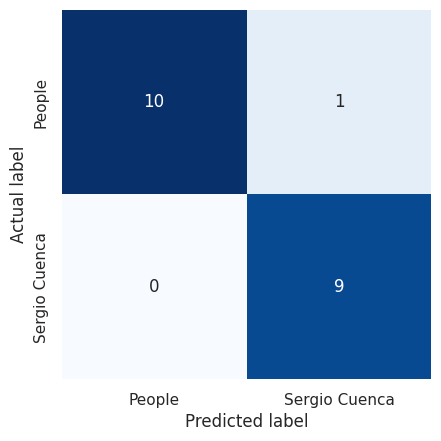

In [15]:
y_predicted = model.predict(x_test)
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1))
 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = data.target_names, yticklabels = data.target_names)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

## Use transfer learning with ResNet50 and VGGFace2 weights

Inicializada con pesos de ImageNet, ResNet50 logra una precisión de alrededor del 90 % en el reconocimiento  en el conjunto de datos de LFW. Pero los pesos de ImageNet se generaron entrenando la red con imágenes de cientos de objetos diferentes. Estos pesos no están optimizados para extraer características de las caras.

keras-vggface es un paquete de Python que modela CNN preentrenadas para reconocer las caras de personas famosas. Estas CNN (y sus pesos) están encapsuladas en una clase denominada VGGFace. Se cargan las capas de cuello de botella de la versión ResNet50 de VGGFace junto con los pesos a los que se llegó cuando se entrenó con más de 3 millones de imágenes en el conjunto de datos VGGFace2 y se usa el transfer learning para entrenar la red resultante en el conjunto de datos LFW. Como antes, se comienza por cargar VGGFace sin las capas de clasificación y congelando las capas de cuello de botella.

Una capa de cuello de botella, en inglés bottleneck layer, es una capa que contiene pocos nodos en comparación con las capas anteriores. Se puede utilizar para obtener una representación de la entrada con dimensionalidad reducida. Un ejemplo de esto es el uso de codificadores automáticos con capas de cuello de botella para la reducción de dimensionalidad no lineal.
Con ello se reduce el número de parámetros y las multiplicaciones de matrices. La idea es hacer que los bloques residuales sean lo más pequeños posible para aumentar la profundidad y tener menos parámetros.

In [16]:
import site; print(site.getsitepackages())

['/usr/local/lib/python3.9/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.9/dist-packages']


In [17]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications --no-deps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-rrp5hk9p
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-rrp5hk9p
  Resolved https://github.com/rcmalli/keras-vggface.git to commit bee35376e76e35d00aeec503f2f242611a97b38a
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8314 sha256=6e93fc6c54d1cd2e6e5842d0f69025e67543c949cb8f501ce6c2053f89da1a06
  Stored in directory: /tmp/pip-ephem-wheel-cache-7zvfd6mz/wheels/7a/c1/6e/91fe8b6b4e174d76dfe5cdbe81806ea3439fdd681c289e73f8
Successfully built keras-vggface
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.7 MB/s eta 0:00:00


In [18]:
# For WINDOWS
# ==========
# filename = "C:/Users/lfsanchez/Anaconda3/Lib/site-packages/keras_vggface/models.py"
# f=open(filename)
# text = f.read()
# f.close()
# f=open(filename, "w+")
# f.write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))
# f.close()

In [19]:
# For UNIX
# ==========
# filename = "/usr/local/lib/python3.8/dist-packages/keras_vggface/models.py"
# text = open(filename).read()
# open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))

In [20]:
import tensorflow as tf

from keras_vggface.vggface import VGGFace

base_model = VGGFace(model='resnet50', include_top=False)
base_model.trainable = False

94694792/94694792 [==============================] - 1s 0us/step


Se añaden las capas de clasificación al modelo de base y se incluye una capa de reajuste para redimensionar las imagenes puestas como entrada a la red a 224x224

In [21]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Resizing

model = Sequential()
model.add(Resizing(224, 224))
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(class_count, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['categorical_accuracy'])

La función relu ayuda a prevenir el crecimiento exponencial en la computación requerida para operar la red neuronal. Si la CNN aumenta en tamaño, el coste computacional de agregar ReLU adicionales aumenta linealmente.
La función softmax se utiliza como función de activación en la capa de salida de los modelos de redes neuronales que predicen una distribución de probabilidad multinomial

In [22]:
import time

start_time = time.time()
hist = model.fit(x_train, y_train, validation_data = (x_valid, y_valid), batch_size=10, epochs=10)
end_time = time.time()

print("###### Total Time Taken: ", round((end_time - start_time)/60), 'Minutes ######')

Epoch 1/10
16/16 [==============================] - 65s 4s/step - loss: 0.5646 - categorical_accuracy: 0.9750 - val_loss: 1.8433e-15 - val_categorical_accuracy: 1.0000
Epoch 2/10
16/16 [==============================] - 32s 2s/step - loss: 1.6035e-10 - categorical_accuracy: 1.0000 - val_loss: 1.8433e-15 - val_categorical_accuracy: 1.0000
Epoch 3/10
16/16 [==============================] - 31s 2s/step - loss: 1.6034e-10 - categorical_accuracy: 1.0000 - val_loss: 1.8433e-15 - val_categorical_accuracy: 1.0000
Epoch 4/10
16/16 [==============================] - 33s 2s/step - loss: 1.6033e-10 - categorical_accuracy: 1.0000 - val_loss: 1.8432e-15 - val_categorical_accuracy: 1.0000
Epoch 5/10
16/16 [==============================] - 32s 2s/step - loss: 1.6032e-10 - categorical_accuracy: 1.0000 - val_loss: 1.8432e-15 - val_categorical_accuracy: 1.0000
Epoch 6/10
16/16 [==============================] - 35s 2s/step - loss: 1.6031e-10 - categorical_accuracy: 1.0000 - val_loss: 1.8431e-15 - val_c

[]

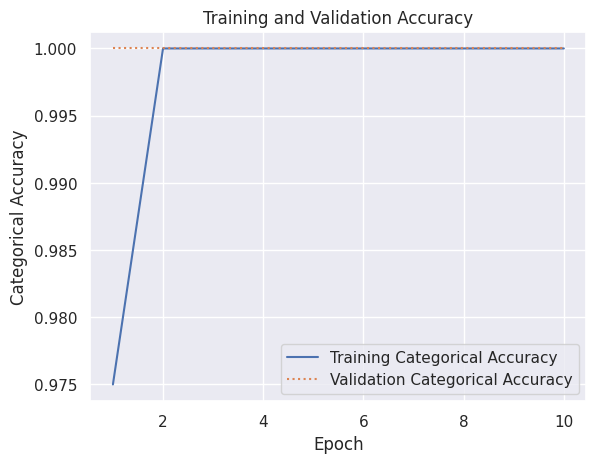

In [23]:
acc = hist.history['categorical_accuracy']
val_acc = hist.history['val_categorical_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training Categorical Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Categorical Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')
plt.legend(loc='lower right')
plt.plot()


1/1 [==============================] - 5s 5s/step


Text(109.44999999999997, 0.5, 'Actual label')

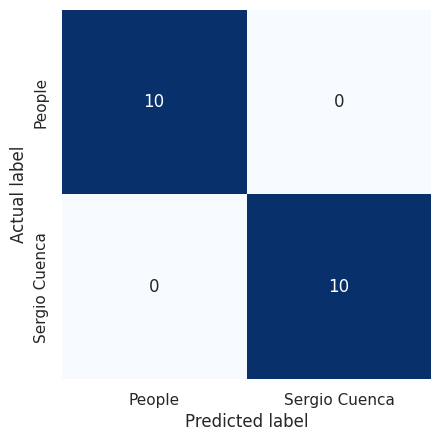

In [24]:
y_predicted = model.predict(x_valid)
mat = confusion_matrix(y_valid.argmax(axis=1), y_predicted.argmax(axis=1))
 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = data.target_names, yticklabels = data.target_names)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

1/1 [==============================] - 4s 4s/step


Text(109.44999999999997, 0.5, 'Actual label')

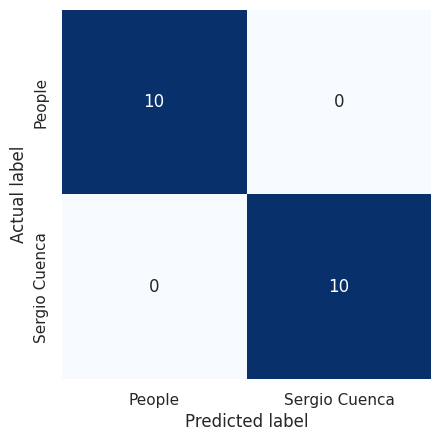

In [25]:
y_predicted = model.predict(x_test)
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1))
 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels = data.target_names, yticklabels = data.target_names)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

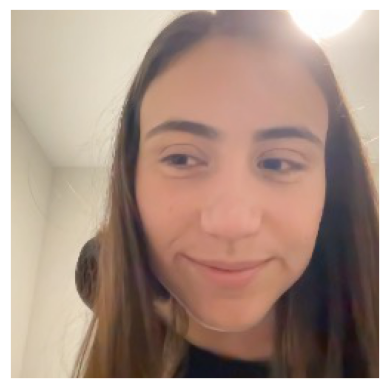

In [26]:
import keras.utils as image

# For GOOGLE COLAB
test_image = image.load_img('/content/drive/MyDrive/Colab Notebooks/scikit_learn_data_test/lfw_home/lfw_funneled/Sergio_Cuenca/Sergio_Cuenca_0005.jpg')

# For OS
"""
d = os.path.dirname(os.getcwd())
data_zip_dir = os.path.join(d, "data/test/scikit_learn_data_test.zip")

with zipfile.ZipFile(data_zip_dir, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(d, "data/test"))

test_image_dir = os.path.join(d, "data/test/scikit_learn_data_test/lfw_home/lfw_funneled/Sergio_Cuenca/Sergio_Cuenca_0005.jpg")
test_image = image.load_img(test_image_dir)
"""

plt.xticks([])
plt.yticks([])
plt.imshow(test_image)

import base64
import io
from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

image_1 = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAASABIAAD/4QBMRXhpZgAATU0AKgAAAAgAAYdpAAQAAAABAAAAGgAAAAAAA6ABAAMAAAABAAEAAKACAAQAAAABAAABXqADAAQAAAABAAABEwAAAAD/wAARCAETAV4DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9sAQwACAgICAgIDAgIDBQMDAwUGBQUFBQYIBgYGBgYICggICAgICAoKCgoKCgoKDAwMDAwMDg4ODg4PDw8PDw8PDw8P/9sAQwECAgIEBAQHBAQHEAsJCxAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQ/90ABAAW/9oADAMBAAIRAxEAPwD6riXGMVrQZPBrOjGQK04RyAK+WaPYgmbUA4FblqegrBt26Ctu3PQ1NjdI6az6AVvwKGx7Vzdo/IrpLVuauL7lyZ0umfK4zXvHhtgbD5fWvBLM4IIr17wlqAGbZzw/T6114SdqiZy4pXhY74Gj600dadn0r3TxxehpCcUhPNJQAtec+KNLEUnnRj5H5+h9K9GrM1eCKeyfzSFWPLEnoMCuXF0+aHodGGqcsjwW4tXPAH3jgfhVIRmLJkIUL19vrVbxN4shsA0FlEjFc/M+Tk+uB/X8q+fvEHiXVb7es07FD2BwPyGBXz6vPY+hhh+57deeNvDGksRdXiMy9QmX+oOAcehrmLv4t+FrBv8AWZjPQjk4I9OK+XtUlcgkscn3rh7+RiGBOcV1Qy5veRThBbK59t6f8XvCF5OFS8CngAOCPy4r1fR9Z07UjHNaShsMOO/UHmvydnnljfIOPpXf+Cvihrfhi6RPPaa3GPlY8rjpg+ntRPL3b3WYS5b7H6UhlU7mIy38qa80IxIeCwxx3xmvGL/4r+FdL0Ownu70Ga5iWQxxHcy8crn/ABIrz8fH3wx5v+smiI6E4K8e3P8AKuTll0VxcjPqyMrIC7uBtHTvUykZ9jXhfh74x+HdbaOLT7tJmHDKWVW55PysV6V6zZ61a3qobfJL/wBOufpVJtOxjKDRvEEgCqkgyOKsZbAJ4+nNQtkHnkGr5jJpFNqrMKusuOKrMKymi4yKLD2qpKo6VoOOapyjrWdguZciVQlQ+la0i8GqEo7VEojTMeRSOorPlFbEq9/Ss2ZalMsypV71Rdcda1ZB1qhKtUSZUq9e1Zky4/CtiUVmyqcmobLRjyj5qqyCrkww1VJBxTTsFjMmA5JrJmwM1rTHisS4baCTTkr6kcpmXDfwjvUSRHGAM1IqmRi1XY4iBnFTqUz/0PriNelX4lxzUEa8CrqLXyrZ76iX4uAK1IGrLjq/C3I9KaehVjorV+ldHaSdK5G3fFbltPREJI7a1l6V1+mXTROrqcEV5zbT10lpd4A5rWJDZ7/pOqR30QVjiUfrWrzXimn6k8TBg2MV6FYeIVkUJcfN7969Shi1a0jzq2Gd7xOop46VVjurebmNwc9qnVg3QjA6nNdymnscbTW5J14FcB451mK2sXsY2+ZuW/wrQ1zxVa2EbR2zBpeefSvn3xBrjXLuzPknNefi8TpyxPWwGCd+eZ5/r8nmM59a8q1RgCSDXeatd7g2T1ry7VbgknBripStY9pq6OR1Rxk1xF+3B7V0WoSOx9a5i5hkk7da9CnUVjnknfQ5i6OWxWVcbo23L39K27qxm3cKarDT7j+Jav20VEboN6o5e/1C5iUb3YjtntWDPqrsMKfwrqtZ06SSIqq4NebXnnWrFGTkVrRlGRzVoOO5opqU8cqyxkoynIZTgg+xr6T+Fnx71Xw9cx6f4hdruwbC+YeZEwMDPPzD1B57jnr8fyX9wCSoxjtVmy1r5tswI9xRicKpqzRyxqO5+5HhbxLpviCwhvLGZZoZl3IynIP0I/znINdM6lTlencV+TXwl+Ll/wDD/VImaVptJncedHnO3P8AGo7H19QPYY/U/RNasde0u31TT5lnguEV0ZTkEMK8GrScNGXJroX2/Sq7LVpl9KhbNYshFJhVSUVoMKpyjnOKB3MyQdaoOK05Bis98YpWG2ZsoPSs6YcGteSs2Qdc1i4jUjLcc1SlXk1pSDHSqUvSmi0ZMi4rMmziteWsm4zioktSkY8/WqEjYBq/OcmsmdsVNyjPnbGTWBP+8faK0bybAOOpqlBGWOTzmm2MlghzwK0kt6ntrfgEitRLcEYxSUmOx//R+wogavJniiGLIq6kWK+S6H0SWoJwKsISOlPWMYqVY6L2BlmKQjitOCXHFZiJ0q3EMEVSZDZ0UFwa2re5I71y0LEHNbELYxW0SUddbXhGK3bfUGGMGuKhkrTim5AFagj0CDVtoyWP0Hf8a5nxF8TBZwto+nuA+f3jr1H+yD/M1xnivxKmg6Q8uf30uVQH19fwr54TV3lcyO5JY5JJ5yahN30OulRi0nI9puvFDTjlya5W91VpM81xqaju4BzVjzS4qpRSR2xV3oMvblmzzXE6gd+eK62Zdyn3rBuIRg5FYe1O2NE4ea2Lk8VWNj6iusMAz0qNrYZ5rN4hm0cKmzjJLIA8ioRZKeorrZbYVUaBRXPPEs7YUElscld6ZFInK15rrnhpJtx2/jXt8kAI6Vk3Fij5BGRWUMdKMtGRVwMZqzR8kavo1xaMxUHiuTdvLOfWvq/WPDkc6k7fxrxTxD4XKs+E2sM9B1FfS4LNYyspHzONymcLuJzmj3aSHymbA7V9zfsyfEaTStS/4QbV7rZbXjBrQueBKxAMYz03dQPXI6mvzru0n09hIjcqa9C8JeJpbmSGa3laG6tmV1ZThldDkMCOhB5zW+Oo80eZbHk0nb3ZH7qKSV+bgioyea4f4ceMIvG/hLTNfDKZpowtwq8BZlGHGP8AeHHsa7plODXhNDasyuwqrIKusvWqso9KSGZso71nSitWQVnyrUgZsnSs6UYJxWlJ71mzd6iTGtzOkqjL0q9Ieaoy4x9ak0SM2Uisi4ORitaXAzWLcHHtSYzIuGFYdy+BnNaV1JgGuYu5ix8sHrSkhcxUbM0ue1a1tb5IqpbxdMc10FtD0rJtmkS3bwjFaaQcU63hrTS3yOmah3Gf/9L7Zt+a0kWsSyl3AZ4Nb0RyPWvkIyPomTKlSqtOUCplWhIGNC1YjGDyOKQKRVhOuBWkWQydMY4rRiJqiimr0Y4rSOwjRiYrVwSbcVSi7Vka/qaaXp899IDiFS2AepHb8aU6lkVCPM7I8P8Aib4peXXzp0EgKWY2scBgXbk9fTgVwUOpEgc5zXC6hqkl3ezXErbnldnY+rMcmtXSN9zKMD5e9d0Icsbs7lrZHpmnys6h2710cUvFc1a/IoArVSTivPqVbs9mjSSRoySDaVrKmIPAp7SseDUGc/WsNTpUSPaD0qN0281bVMCo5Bxis6jOilEyZF61RdfateRM5Iqm8fGa4ps7KcbmaV9qgkhB7Vosh6VEUrKT0NOQzWtlcYYcVy+r+GYbxSVGCOld0E5pGTJrNVrak1KSejPjbxn4RmtWlOwhWzXj+kXMml6qkhbb821vpmv0K1nRLfUYSsiA59q+SfiX8PZNImOqWa/uifmXHQ+tfU5bmanH2cz4vNcrcX7SCPsL9l7x8dP1SXw7cP8A6NesWQZ/5aKuePqvP4V+hsEokXrnPIPqK/CbwF4oudLnguoXKXFuA6Edd8B3fqpNfs58PPFNp4t8NWWr2pDR3UYkTBH4j6g/4dqmrHlZ5MldXO+ZeapyCreTgHqPWq8nNYMzsZ0o4JrNl9q0pc81nyDrSHYzZe9ZsorSmrMmbrUtjSMyXis6U4zmr8xrLmbk1FikZ87HtWDdyda1LiTANc1eTgZB7U2glIxb642AkmsOJWlfcepqW7k86YIDwOtXLSI8GspSKii7awdOK6G1gHcVVt4ehrobeHpisrmqLEEQ4rVjgJHApsEPpWkkfHTNRuVc/9P7NlgktZN351r20oYAg1sapp+CxA4Fcym62l2n7pr45bn0DR0kZzxV2Pke9ZUD5ArSjb2rRICyBmpUQg5qNParMYNOO4pEyLV2JSfwqONRxWlb28kzbY+WHOMgE/T1rUhhGNvNfPvxo8SGz0ttMik+eTkgHnnC/oea981GU2EDPJlSvqOn1r4D+JPiaPXNXuVjbIgcBSP4lHX9elRCPPUUFtuzswy5Yub+RyFtO80wjXua9i0W0+y26AjkjJrxrwgPtuqqhGQoLH8K98t0wBXTmNS1oo9TLaV7zZpwkjk1eUnHHNUV4xVpM4rx3Usz14osdeaei80ipxSg4NNTbNoU7kjMBVdsmpDzSFS1EtTdRtsViuahZMitDy+KY8YI4rnkrG1N22Mkx81EYzWiyVGUrnaNrlAxnsKPLPpV7aKQqO1YSiDZQaPI4rnNf0C21ywms51BEikdOma6wpimBOc+tRCo4u6OStBSVmfnVqen3PhnXLmxkG17eU49wOD+YNfoD+x747FzZXPhC5kINu7vFk9P7wA7dc/ia+Vfj3pyWOrrqEa4M8e7I7lTg/pisP8AZx+IH/CLeO4rycnymZCSoyflODjjPKblx6kelfbRXtaCqH59iv3dWVM/b4SgsASAW/I+4pr5ziqivHMgMWVzyoPBU55HsfapvM3ZB+8vUV5xgytJzkVmyVoyHqfWs2boadx3M6bmsec9a1ZjWLcE8ms5lGfKw71kXDVoStWLcycGmmCZlXUgANcfqVwFG0dT0rcvrgKDngCuOYtPMZD06D6VLBEcMJZhnvXRWlv0qrbwnI4rorWHgcVjItIt28IwK6C2h4qrbwdK3beEYrK5ZNDF6VfWLipIIfariw46UuYk/9T9NNUsOoxXn2oWIDHAr3HUrIHJArz/AFKx68V8ZE+i3R59bsY28t/wrbifIxVC7tNrZApbaXPyt1FbxMrs3FPQ1bjNZ0bVoRHNPZlXNOL2q9HgDPSqUeB1PFTh1PBbAHU+9JyJa1PMPiv4oHh/w3clJMSzKVCjkANxnHr0r85LvVo3nKxyMXbO/IwPwOa+i/2gPFIvNUOmW75itly2D39P618YPet9pY5616mT0bxlPubYmfLFRPoL4YyCfWJgT0iP/oS19CRrjGK+XPhLfqviNYXODPE6r7sMN/IGvquJMDcxxiuXNYv2lj3MqknSJI0PU1a4UVw+qeLbW1kaOFwyp1Oa4u7+J0cEhSNN4HeuSnllSeqR0zx9OG7PcUfjAp/NeCp8WFXJkhNb2n/FbSblgkqshrSWV1Y9B0s2pNpXPXwM9akwAK5LT/Fem3+Fibk9K6WOZXAIPFcNSLi7M9elVjNXiTD2ocdqNw61nXuqQWiFnPNYO70Rq2oq7LDjB5qvJLEnVgD9a8l8RfEWa2DrZIPl7+9eE6r4y8S6jKxN26qey8fyrspZZKW7seZWzeEdErn17capYW/+snQfiKzv+El03oJVP4iviw2evag29UlmJ78n9a2rbwx4pmx5sL8dCTzWtbLKcdHM5lmdWWqhofaMN1Bdxh4GDg+nNK2U6181aFJ4u0B90bNgdQ3IP19a9j0PxlBq2La+j+zXAGP9lj7en0rx62DcVdO520sVzaSVmeBftGygjTgT1Scf+g4r5J+G2pTwazG0bYeFwR+BzX0p+03dtFc6RAp++Jz+A2V8l+BJfL8RDJxlhX1+UpPB8r8z4fOdcZZeR/Qf8MfENr4k8J6ddrM9zHKi/vZBiQsmBluv3uGJ9zXpM8e1RInDx/qvcV8sfs4eIo7/AMGWsUcZ/diJCo6ABPKY/iyEn2NfUpby38vkqRkH09q8me+pNSNmQs6sMjvWfM2OKsthQQDkAn8jVCZqhAZ8x4xWLcNxWnOw65rDuJBg5NDZKMy4frXO3kpAIzWndTYzXJajdhFLUrELcw9RuDK/kKevX6VFbwUyJGdtx6scmtq3gIHPNZzZtFEttBjFdFaRZAqhBF7V0dpDwKykjRMvW8OeK2oIucVWt4TxW5bxYx7VmBLFHxxVoIe1SRx96n2U0aJH/9X9jdTsmQkEdeh9a4HULPBPFe33Nqk8ZRx/9avO9W094XKsOvfsRXxzVme9F6njuoWnJ4rmJYTG25eor0+/tAc8Vx95agE8U4SsaNGXbzBx6HuK1YT6VgSK8D+Yv41q2sokUMtbNkNHRwyW5TZOpX/bXkj6qev5j8a57XLh9H0m71Oe4VY4o2YEDOTg4HPI6enQVrI4IGPqa8H+M/iNrDRru3Evl71CgH3GcY98VzVWtkdOFp8z16HxD461+W8vLm6lbc8zEn8a8XM5aXOa6nxDebg8rnJNcCJxuzmvtcBQSgkjxsXUbkeu/DzUjbeKNMZzwZlX/vv5P619X6zqOoXrGz09WEYGMjqx7/hXw94auyutWBU4Ini5/wCBCv0Bt4YraLeRljXk51aE4s93JLzpuJ5/H4HuLyPN5M0WeyjJ/OnN8NNM24DOT6mu2n1aO1GSC7HgADOaja41mb5hst09wWb+gFeUsdV7nuLL6VtUedXfw2sUXKSup/AisKXwEifNFNyPUV6tcfasHddMcj0X/CuWur+aB2AcSKP7wwfzHH6V108ZVe7MJ4Ciiho+k3djIgU5Udwc17jp+WgT1xXkml6nHdHzIxtKnDKeor1zQnW4hwO1eXjqrbuz1MDSUdEXSp5FchrVm8ysoGQ1d7LDjpWDqbIkR9RXn0qup6NWjdanhl74XEzbJWxGD0p1r4V0iHDGIMR3Irp7+4VSXkOAK543nntunOyBe3r9a9L2tSSPNWHpReqN6CbRbZRG0kUeO2RWrDe6VJ8sNxG59AwzXm1/418P6Wv+k3KRpnHy8/yBrPtvid4JupPIkvF+bj5kYD9RXE8vqPWzOn67TXuto9nU2xYAqrA9Qeaq3nhywuh9otB5Mi88dDXG2rRzFL3R7gTW79VVtwHuvt6iuysprlF+bpXBOMobs0cYyVz5H/adSVI9EuH6xmaNvqwU/wDstfKHh92t9bjkHG5v519h/tNwNPpFnPjiCbcfxBH9a+QtLiaXULd1GBk/yr7PJ2pYP7z4HN6TWKbP1S/ZP1jFpqNiJcSMu6LJ4DRncw/FN3419+PJLESjndxlGHcD/Cvyx/Zl1X7J4gu7WU/I2QvODveRI8fk5+lfp5HdGawQggtGAM/T/EV5dSFtDOrvcla4wPM6bgcgc9DVd5kkXcrZFLdMhICnGen6ViXEnlNk4IPtUJEIW6lABFc3dzjBGasXVyDkZ5rmb26UZ5pJ6jZWvbnAPNcZPM11NwcoOn+NT6heFyYkP3v5VFaxEEGm3qSkXreEDHFbMMXIFQ28eQK2YIqxmzVEsEQBHFdDaxdDiqMMXI9TXQ2sR4wOlZOQJFy3i5xWxCnqKghjxj1rUjTAxWauUkOVfaptnenolTha1igcj//W/YLwl41hv0Wy1GT5+iyNx+D+/oe/1rtdQso7mMxyDjsfSvke2vHhkEkZwRXtXhLxzFJGunao2FHCuT932J/u+/bvxzXya00Z7s421Qatp7wSMjj6H1FcRe2vPSvcNStY7qIoeQeQR2968y1OxeFykg+h7Gs5xsxxndWZ5neW/BGKwQ720mByDXc3lq2TgcVylxbOJORilJlIkj1F4x86tgjHDbf8a+KPj74hWbUvskcpYjgjt3JOfrx+FfYGuOthp8lzNwsalj+Ffmv8UNRN14hlYPuBYt+dGBh7TEJS6HfFKNCTW70PKtdm3ALnPJJrki/zYFbOrTDiuWeT94TX3mGkkrHztZWZ3fhEGbxDp0I/5aXES/mwr9HJLVjEpHTA5r84vh8ftHjHRIwMkXkB/wC+XBP8q/US1gVrZVI6ivmeKKvvwXkfVcN07wlbueTajf2mjO1zMhmdM49BXDXfj3VdTkW2sEFuGOMn/Gvf7zQrCQF7mISDHeuauPCOjSRuYIlRscDHQ15OHxlOK95ant18NUbvF6Hgvjka3pOjw3sV/JLJM2GKngcZ4xXh6eKNfeYbLqUkH1J/SvrTUfB0WNs8u+P+6elc3/Y9naSGO1gBx2UYr6DC5vThT5XC7PBxeVVp1LqVkZnga6v7q623iFgIwxfGME9VP1r6P8KpsTnp0rzzRdKmkVEVdoPJFet6Vai1jWMdRXzWY11OV0fS5Zh3Famrcr8vFcprCfu2J9K6+4A21gX8AlQg15kT3HTujxvX4JmsmezXzJl6L65NeYmw1V7hP7ahZ4VPKoe30r27VbCeMHyifrXGzxXm7nLAdjXp0cTaNkeVPC3laR418R9EtPEllaW2hRfZXtywbzPlBBrhvDnw08QvLGsoSdEOfkJJx6ZxxX0/bCNW/f2ZfPUhc101le2lt8sNq4B/2cCuv+2ZwhyJHDLIYTnzs878M/Dm80d0voZ5LUkfOmcqa9VtkZFCSc+9WEuZr1wpUogq8lqEU183icXKpK8j2aGCUFaJ82ftA6ctz4SudoyUwR+dfDnhVi+oQQsckNX6GfGW1Mvhi8CjohNfAPgm1D6wkuOIzmvqMmrP2DXS58ln+HSrRfkfYnwVv4NI8a29yylozc+X7jzsRg/gWBr9PLLUoDAV3jG0rx6gnke2CPyr8l/hxewx6sj3K+YrOcAdSxb5cfjg1+nOiyrcaek5JBk3OfxP+GKxrSs7o8rEwVk0dfLqtv8AIN4+UAVk3er2xBy4rOkjYuRj73P5cVk3MGMg1jz3OKxHdavAAcSCuT1DWYjkK4zVq6gySK5G9gKtk9jSUiuXsaNtumfzG6muhijITOOay7CPgV0sUWEZj0ApOVwsaFpEAAa3IIqrWsACitmCKsJO+xaRPBF09a3raPAqnbxjGfStmCPPSjlGmW4k5rSRMiq8KdK0UXiqSC4qL6VMFp6rmpNtUJn/1/of4f8AxPi1tY9M1orDfDCq/RZj/wCyt7d+3pXt0FwysGQ4Ir8/YIihG3jFfQfgjx/Naww2OvuWibASc8lecYc+nv27+o8DE4brFHsYeq5fEfbPhTxg0arYag26LoD1KfT29u3au8v7aG7hzkMrDKsOfxFfOVlcqyrJGwYMAQQf1Fej+H/EklsBbXRLxHp7fT/D/J4VtqbTjYi1K0ktnKP+B9RXJtE7zAV69qEEF7bggh1f7pFcJPZG0mxIOmSPesJJIcddj5++MGrDTtHnth8rSgAc84UZJ/MivzL8SXz3usXFw5zuYn9a+3PjvraSLfyRsStuAD/vHbgf99E/lX5+TXLSyPMecmu/KIaOoehiv3cIx6mNqj/Pk1zLXA3YrW1WXrzXHyXCq/Wvq8Pdo+arPc9b+Ftwi+PdD3DrdRL/AN9Nj+tfqrZH9yuOwr8d/BOqrY+LdHuycCO7gY/g4NfsLpp326sO4Br5LihNVIPyPtOEUnCa8y3OgdNvrXP3OmxnO3Kk9cEiumKEnk1C8QPJr5ZTPtFQuedS6Ckj/OS2PUmrdp4ehDbioGPauz+zpnNPEag10/WJJCWFXUqWljHAAEXGK1448c0sQUcVYb5RkCsOZvU05UtENn6AVlyIGzVyV2wc8VlysynK049zoUWkZVzaqchhXOXGnKx+Va7CT50LDrWYV5qHUsNRUjmhYbOgpy25VuRXRgLjpzTDEjHHQ1Lm2jWFBXKEMW0ZxVpvu1YKAL06VXk4U1z8o52R4/8AFfb/AMItfsf4YmP5V+fvgLgXN2w+6MD6n/61fcfxy1JdP8F6kSeXiKD6twK+JfDoW20xIE/gRpHPqTwK+rye8aD82fA8R071o+h694Hci6s3j+8sqkf8AXd/Ov1N8E3C3Xh+0f8AjCBH+pAP9RX5UeAyzapp0f8A03jP5sK/Uv4YN5mj28G0YCjLDuQuwZ/75rKvrI8ivC1NHYPB+880cAjH8sms67h+XjmumeL5Dkcj+fes+WLyxuI+ZuntWLkcXIcZf2ohTYR+8P3/AG9B/j/9auOvbUspPYV6Ldw5HNc3ewbk2hcbf1q0TYoadHlFrqkhBiCf3yB+f/1qx9Ki+XB/hrqrePfID2j/AJn/AOt/OhiL8EQrYhiAAqvBH7VsRR4GDWexViaCPH0rWgTAzjFVIowAK1YUpxFYtRLV6NKhjXjmriDsKoCRV/KpNoxTlHYVJtIptAf/0H2ZhuQJIHEinuDkV2FvFKkcWwfw8gjI6mtiLwLYadpskulW5jYENjczFh3+8TWhpthLcxxiGMuwJGAM187hc2o4mPNRex79bAToPlmdL4W8XalorR29zCs9l3UA7lz3Ugj8q95sde0q5hWVWbDDOdw/kQDXlmieCdVuSrPF5Ser/wCFeuaR4ItLdR9scykdh8q/41jXcG9AjdKx1Wi+KoIXEBl8yNj0yM/hyea0NcvUEMlyxyVQ4HTAPr78VFa6dZ2S/wCiwqgB/hHJP161yXj28/s2xCyvtWcEMB1x/EfyzXmYupaDsdWHpKU1Y/PP45a6Dpxi3jzLmV3bHpu4H8zXyKJfk3E9Sa9X+Lusi/1Fwkm5UJwemdxznFeNS5QInoOfxr18o9ymkXj3zzMDVro7H964ppm3/Wuj1ssEVc9a5CR8H6V9dg3pc+Yxis7Gra3Ekc8cqHDIwIPoQeK/Zb4ea4db8NabfOwJuLaKTI6fOgP9a/FqJz1r9NP2XfEbax4BhtZBtk0yaS2JzncOJFP5Pj8K8Hiuj+5VRLZn1PBmJSrSpPqj62AyM1FNgU1ZuB7VSubnAJr8+jLqz9ShAc0oUZrOu9SSAcdao3d4yLxXPyCS5Y05VUaculzuLS4ae3E4Oc+lb1uC0IZ+TXP+HEjSyMEuNysfyNb5njRGUdq0gZuNyOVUdeuCKywMkg0rXaZPNQrcR9c1SkbeyaRRu4nSUBDgGub1C/ks7wWzegP4V2LyRSuGzwK898RPHLqIeM52oB+VRUinuYwVtzUivUcbs1aMhdCEOD2riYLo7/Lbit2GfADKc1g0nsdMZHSK2UBbrVO5lREJ6YqsLsADJrB1jUo4YHJbAAJqqcbsxqtLU+VP2i/ESta2+k7uZZCxH+ynP86+ctLnA0a8nJwZCiL9BV345eJ2v/EckaHKxDYvPqef6VzKyGDw4iE8yHj69K+8wmG9nRjfdn5tmWNU67R7b8PJfmtLsthhKGB9MMCK/Uv4YxtGkttnb5eGjBPO1iD+Wa/KzwUnl21pF7A/nX6OfDnxNC09gkbF5Li3hjKnAwU+Xg/U559a8OtUSqNMirSc4aH0mhV5Cx5yDj65qpNE8g3lcVp2aK6b052ls/8AfZBB+lTSoCvtWLXU8xo424t8iuduoMZNd1cQjFc3dRAkqOtUmRZnOaeuHZQMkngV19rDtUL1x39TWFYwBLhieprrraPA9ab1CxcgjPFa0SZwKghjwAPWtGOPGCaTVwuSonNaUK9KqIvStGFelOw7lyMY61bRcc1Ag9KuJ2FUmJkijHPrUgBNAAxTgOKd7DcT/9H6v82OQLAtvsU8HHOOOua1PA0yxa5f+HbiBQ0aLdQSADLRO21g2B1R+B7EemTt2sVp5eFYZxTvDVgkXihbh8hhbyxL6HcyN+myvwLhzMuTFcl9Jaf5H6tm2GU6LdtVqepWtpEFBJIb0xxj65rXih6iMgn3OP51FGm1cnr2rTtbcgbiOTX6Pfoj4yQiQ7PmP8Iyf6Cvnb4z6i/2edlOEtISX5/vAsR+VfSbIWAXPU5Y+w5P+H41+f8A8f8AxCY7fUZl4Wd2UDP8Ibj/AArnrJtxiup35fG8732R+evjK/F3qhRD1bmucuZlaZsdFGKLub7TqpkJ6txVFvlDP719LSo8tkjCpKzucr4huB5wTHAFcZNMN+K3tZk8y4Y9ccVxrPumOOor38K21ofN4+ouY24pgOvSvsz9krxR5Grax4eeQ/vkjuY17ZjOyTHuQy/gPrXxLvCqSeor1f4FeKE8P/E3SJ5WxFcubYn/AK7Dav8A48RWObYV1MPOK7X+42yTGexxVOfnb7z9hU1BWUqDzjNUJrsHvXPx3cjIcdDULTOGxX5VKF2ftka5pu5lOK0rO1GNzCse1dcb2PTmtdL2MjCtSjHubOrclumu7Yia0PTqKxm1vUVcpNEceo5FbbS70INZ3chulac9mLnM19bUA7221UfXSiMyZaszX448qBwxPapbS3jMCsOeKrmRarPYntta1KbOI/LU9zyfyqLa0speQ5zUxyo2rUDsVUsvJpyasHMQ3MOOV4IqrBf+XIYZDtb0NNnv/JH77isu8lt72EbCCy8qR1BrJQuRKodHJehV615H8QfEyWGmTMG5Cmuin1CSGEq/UDvXy58W/EW+GW2jbjBBrtwOGcqiXQ8vM8XyUm+p8va7fTa34mYyfN5kufw7V2OrMALSyj/hxXB+HUNxrXnPyVyxrs5W8zWIIupyP519tXq6JLofmkXeV+59BeE1HnwoRjaAPyFe4ab4h1HSmWSzO10G0HuFyD/SvF/CnF3bk/xAn9K9DvGlS0uniOZVTeB/u18hiKblUPp6VlA/QT4R/ETSfFFjb2Ru1GpFD5sBOGYD+IA/e9yM++K9mK/LsJ+lfigdcv8ATp0vLGVoJ4djROrEMrDnII6EGv0+/Z++Kv8AwtbwcZ9QwNZ0plhuwMAPkHZKAOm7ByOBkHHGK7qmGcY3PnpyXM0j2G4iBHXpWLcQAfdGK6WVQ1ZU8XUGuaw4nLiPbcr2zXS2yHArGkjxKjehro7YcU7aETZpQDmtFFqrAuRV9OtCIJIxyK0IhxVNB3rQiHGaoZaiHNW19qrxjvVpelAh61ICaatPAoLR/9L7Rt9CmUjy2CD161fsb5rXVbWO5BDCVQGA4OTg/mKis/E9g4Mbttbt3rWs4ItSu7cwncTIvI7c8mv5Rwc6kasFFdV+Z+5YpXhLn7HsMURYjI61vQRc4PQCqNsnI9qt3Uv2a3JH33BwB1Jr915j8wa6HNa3qlrZ6LqepMxRFR41yRnOMZH4nP4V+Uvxy8SfbYTbZ4ye/YE19m/GnxZcWcw8NRP5SKolkA9doOD+Yr8yPihrTXd3LCGySTz9K5qEnUrryPdp0fZ0eZ9TyG3bzLzf2GTVaWQhCTz1pbUlGJ6YBqnO5+zO/wBa+uT11PFnFnB30peRz7k1ygfNx1xW9dyAlmzXORndcc9M17OHeh41bD6tl+eTEZB4qlZXctpdRXEbESRMrKR1BByDTb2TbGQDxmqFu29s55zXbG0k0eXNOEk0fsr8O/Fdv4t8OWOsRcfaIlYjIOG6MPwORXoLAbCe9fnR+zt8SJNEvx4X1GTNvcnMBY4Cv3X/AIF29x7197yaqJbUGHqwr8wzTBexqtW06H6/k+MWIoqV9epmXms3JuWsLJNzDqc96rw+JNS0OZTrVgzwMeJIvmx9R1qfSrPyrkzvyX712UltBdweVMoINeP7VdT3OVLcLXxdotygaNyB7ihvEGkk8SgfWuSv/DNrGxaJjGT0Ze31HeubvNC1mAb7aWO4XrgjaTXVCkpK7PQhQTV0eiXVxpl9/wAtV496rnV9LsoxCXHFeOz3GvW4P+gMSOyuP8Ky2n8U3Q2x2KW7ersX/kBVRoK+5usE7bHsz+ItIXJ3nj2rDv8AxvpUCHygXbsoHJ/CvOrPQNYlYvqt2xX+6oCD9Of1rprHRrKE/LEAO56n86HTitzKvS5NzEvL/W/EhJI+w2o5A6u3+FUdMmlsb/yi5MTjByc8jvXTarcRQtsgGFHFcVcXDIzSnjJ4NaJp6JHl1KpZ8V61Ha25CNyQa+MviDqrzrK27Oc17X4t1YurAt0zXy14wv8AzpPsqHLMefpX0WT4TXmsfK53iuZcqJ/CNuS8s/dlrd0f/SfEXzchCOfpTvDNqttpTTt97b/OneGyg1GSbqSQP1r0cXDRs+dhTs07n0f4ZVTeWeOeBn8a9DVA9zPCTw8bZrzzwf8ANqcSntjH0Br0kKFluZj2GB+eK+SqVPePoqS91nzTq/iJ49dewT5lQH8SOo/p9a+l/wBjTx4umfFK00x2VbLxDbTW/wA5xslBWSPBxySyBAP9r1r5C1S1Darf30koiMPmRHI7u3ykfWuj+EWut4c8X6N4jySunzLIVU4JeJ+g/ECvf+KGp85Xpcsz+gG4jAPFZM6YFbbHeoJFU5k3DGK8hxEmctcpxkdq2bMZVT6iqNynBFX9PBMS+o4rPYLG5EMcVbVcVBGKtqM1ZDJUWr0fAqqq8VcTtQFi3GOKtD7tVUJxVhTkUwJhUvFQrmpOtNMdj//T+/JfD2kiH54Ru7HvXReD/D9tZzyXiszY+VQTwM9SK84bxcHdzqcL2gjUsSynYABk88jpXuuh2/2ext1YYYrls/3jyf1r+feFcM6lb2klovzP1jPcTyUuRPVnQQqeWxwBWVql7BasZ7yQRxxAMcnAAAz256kdKbrWvWGgWRur1ic52RoMu5HYD09a+VfFfj2+v7+4lkkSSWciNYQWCxxkHPvkYH4/lX6NOSiudnymFw7qSsjzH4za5b6preoahb5EBXahxgkYx7+lfnn40uFk1GTb24r608easxtpM8eYSPwWvivW7kTX8rtz8xrkyqDcpTZ72YRUIxgjJ37d2OwqtqO2LTj9M/pTJpNi7e8mB+tVvEknlwCMcDNfU4ZtvU8OpJbnnN5hUJJ6VztrKPMJHJ75rX1mQxWhfP3jiub0tzKXJr6SlD3bHiVpttlm9YlRjoear2uVbPapL+RVUDFQWrFyMdBXXCCS0PNlC8rs6WyupIZUeNijocqwOCCOhzX3N8H/AIwpr8KaDrriPUIlAR88TAcZ5/i9R+Ir4KXJPHFdBYyyxEzwO0UsXzKynBBHIII6V5uZYSFaNpbnrZVmE8O7rY/XvTbtJAMV0UczdM18RfBP41HW54/DfiCQLqCDEcnQTADof9v9D25r7Vs3S4RWHQ+lfmOZYOVGdmfp+X4yNeF0WblllTa3fvXJXFzNaOU3fIencV189s4jJTmuZvrdmQ7hXPSrW0Pdw9VwMdtVHZR+VV21LdkDFV5oIgeVNVxAqnKrXX7TQ6ZY530Rc3NIcsabPOIk2pSJnGCOlZN/MUBAptp6nBiarkrswr658yQ5PFcBrmrpEjKp5rb1i78iMnPJryfVrtFjNzcH5WJCKPvSMOcD+pruwdDmZ85jMRypo8/8Y+IodPtmnnIMkmVjTux/wHc14TEHvLvz5juZjk1f1Eav4j1WW+uFJx91RwqAdgDV6HT3tvLVxhmwTX2lG1GCj1PiqtSVWeux26t9m0UjpuAqh4bjMl9GgP3pFH60utSmK2igTvg/kKseEyE1CEn++D+VcNetdWLjuke+eFZiusw46Yx+RzXql1/x4XTg42rn9a8g8LTA30bk/d3fzr1yJhJb3UR53Jt/PNfI4tOM7n02HgnHQ+XfFFl5V7cy7srdzqn0OGIqX4f6Ndaj4itNGhG64uZQqgd3kkOPzrY8UWUjyifbkxSxSsvqFGK+mv2UPhgPFfxKs/EUqkWOjItxK2CAZIyDEucYyWIJHdQa9ulXvT0PAxNKzuz9apYUjAA6YxVCQY4rZlG5drdV6VmyxhhXHzHGjAuIwc+tO077pX0NTzqRwagsARK4+hrOTKOjjHSrSjmqydjVkdaaZkydfWradKqrVxOlVYbLKHirC9Krp0+lTj1osCJVOKk9xUa08cU0Ox//1PpD4seJba7TTPBOnN/pur3cCuB1WIOp/wDHiRj6Gvs1mhtLUyXHCIuf8Pxr87Ph9NB4++Kmg3FsQqaWfOZpH8yWUROXBPAxj5VA7Yr6f+K/jQ6Nb2ifMbfzFkIU/wCsKnofbNfm+AyxYOhGlbXd+p9xiazxNW62OB+IXjjT57r7bq006WwPlqIAuQoPBOSvHXIzz9a8Y+0WV/M+r2V68scalNrwiPJJxu4kY8j1Fc74pvV8SWtvaRvsVWZGHcuh6H8CKsRW0dhprSbvTI9hWGOnzR5Wevl1JRlpseL/ABJ1ZbYTID/qo9o+p5NfJ8lx5szO3JJJr2L4m6k0krxk/PKcmvE16kmvWy+EYU15nDmlVzqaCOd80fuy/wA6z/E8wLgD8Ks2xaW8jUc4JNZevEPdqD0XI+tetSq8up5sYdzz7xbKsVhCo9R+tZWkpmJmxil8V3kcsiWxH3Dmk0p/3NfSYWbdK5wYmqr2sVtYxGoJ69Kj01wwApdeyY1Oe+az9LkOcV6Eb8l0ePiHzSR2Ua5GBxzW9p8O4Oq91asS2y20V09hG0ZL9iCPzFeXWranXhqXMYmmM1rfrcQsUdGBBHBH0Nfpp8H/ABxLrelxWupPm6iUZPTevrj+dfmlDAVvCvbcR+tfVvgm9msI7W6tm2yxAH/61eDm1BVYa7n1GU1XRnofoZAUkTPXNZ11Gqk8cVw3hfxdBqNqhLYfHIJ712M13HMm4NXxNSk4u0j9Dw1aM1dGXKkIOSoqhJGpz8vFSPMGYgmmtIgXJYcVlz3OrRGPPEA2MYFcVrcojJJOAK6q/wBShUkKeleZavNPfuwz5cK9WPf6etd1GLa1PNxVeJwev3asjTzki3jIBx1Y9lFeYSs2p6/Z3UwxHG22NP4VA7f411fjG7la6tdPhXbBGN+PU8jJ96w9kWn3eneccGUMT9R/+uvXpVla0T5XES9652k/gzRLUfb3ABI3Ee9eG+JRaz6wEtYvLRBj6+9dv408eJB/oMLDcOBzXltlPJeXplkJJbnJrtwynHWbPOxHK/hRn6/Mv2mOPP3RW74ajAaK4HUMf5VxeryFtSl5ztOK7Lw9n7Mp9c1pVldXRwxs2epeE7kFwxP8Q/U817RaH9zOw65U/ln/ABr5y8IXoW5KZ6t/WvoPTZw0GSeGPX8K+dzCfvan0eBmnEu6N8NNX8eeIrHTtHgMpuBh26JGoOSznso9fwHOK/VP4WfDnSPhp4Wh0HTMSO+JJ5u8suACfYDHA9Pxr5s/Z8eHRb7V/D11hLtIllVx1dMbhg9xhhx9a+ytOST7JDKjbgEA5zycdRXXRl+7SPBx8r1GSyfL1PT9Kqk5HvVmSRWbcvRuCD2NVGG047U2zkSM65XqaoWxKXAHrWpMMg1k8pMje+PzqGJHTRHgVaFVIuAKsitkiGy0pPFW0PaqSH0q0jVdwLSEVYU9qqAjrU6mpEi0DT81EDmnA4q0U2f/1e5/ZhtbS18RXWpxxPbzW1pIXXO6PbjG5CeQfUEkZ6HHA634oy3t/DFep51wsTlShOEAUkkoeM5zkqeR2r0D4LfC/UfCnh/Ubu5m+231/GY22ghEUEnC8c54zwK8Dm+KWji6n0vVrabytxXInQBXX5fuMh+mdwr4/M5qVRqnqj67ARlFK+5y8FxDeyLLEoDhsELnDqP4ue46c81ta3dx2+mtg4GMYqjZajoup3Mk+jrKio2FZypDk9fu8fqawPG9ysFi+W+4jOf6V8xKMnO1j6+nDS6PlDxrqH2zVJZCeAcflXAtIACfWtPXpy85bOS7E1iHB2rX01OPLFI+drRvJsnsdqXLynoi5H41zusy75fMU9MmtlTsS4wc54rm9RYRWjFzzziuqhTb0Z52Ik1ex4/r05bUWJ5wBmtjSMmJSe/SuYv1aa6d8/eJNdT4ePmbVYcCvoKMrJXPLqQlJqI3xEnlxRljjIFZukYZ+Oprc8VIHtlkXswWsrQYCzhqt42SXKhxwWtmd1bQFSCa6+3t/wB3Hj+I1hwx/KuecV2dtFn7Gg6lv6V5WIxHVHoUqNtjkpYGj1BGJ+Vyf5819CeFXzbJz0FeK6hAUaBz13yfzzXtPhO3d7FHH1rz8TiLx1Pay2Hv6nqOn39xZkSWz7Gr0PT/ABdIyAXDEH1GSK8tgUrjNaUJJYYrxZWlufSwilrE9ZHiWzxuM36H/CoZvE+lMhEt4R7KjEn9AP1rhFxsxWbcxr1zXO6cV0NHVns2dRc+ItMBzaW0k7eszBV/75XP86wprq5v5DJOfoBwoHsKxt6J1NV7zxDp2lwPLczJGqjJLMAB+dJxk9Io551Yx95s5/xdGLa7huW6MhXPpg5/rXmvijVYibMwvmSJSOOxYis3xL8SLfxDdiw0lxLDuw0vb/gP+NYUNq1w0gJ+b5cH3r0aGHnCzkj5zE4qM2+Q4LV5bm48Q7ZmJUYOPqK6bTbkpM0hGAo4qHxBYCO+trsDAdSpPuh/+vUIcQxSSD0NeundaHJe0TEuJzLdSSEfeYn9a7zw9KBpzEnGwn8jXm6sSTznNdl4fdvImXPy8VNZJKxhTV2dXoUnlX0QB+9zX0Tok+/TYjnnJr5nspdl/bY9CP1r37QLtF09WboCa8LMkpJOx62BTi3qfY3hbWhp954X8YQk+XLH9mnUHn92SMfiu79K+/8AQrpJbT9yQyDlfQg8ivy6+GeoprPgfVNOY5udJnW7jHcKewH4H86+7Pgz4m/tTQ0tZ23PbBYyRz8oAKN9CDVYaWljjzCN1c9hvxGQJ0+VsjOKrvypx1q1coNjq3TBwaz42KJsbnHettDzUV35XJrLuOBkdjWnIfmKj61mz8qaTQ0b8TblBq0DxWXp774EPfAFaIqrk2LEZyatIappVxBTuFiyp5qVTzVcVKDkUxOJcWn5FVVYjmpdxxWiGkf/1v1YsNMt9H0d7S3yQiMST1JI61+KvxH0a8h8Y3umWagB53KhjgAOcjk/Wv2x1SbydLupmOAkTsfwBr8yfH/hW1vvEY1s85VcjH8S/wD1q+HrVOXfqfcZfTbvY4Twpo0uhWVtY3k8TTANIyxktjP4AcVxPxB1NI479N2eAuT9BXb6eVSe+v3OfLUoPYA8V8/fETUX2yR7siQ5JryVGUqqij3vbKNN3PDtQn86csagi5lBJziqsjZc80+MlTvzkgV9FVlayseDTqcz1LQA8liOd7E1wPiS68sNGOML0r0KOJzAvGAMmvFPFM8hvpI2bp6V34JrmucGNn5HJXEgV+ec11XhbEiyEdVriLljmuu8HMyq5b+ImvYqp8tzy411exs6xE0+nsD1DiodHiWIKv51tXUWbV19eawrdvK69zXn2V/M6VW0PQrEbiM8iuwt22SRMP4Oa4PRJzKcH+E10k18lsu5uuMVwSl7ziepRa5Lsnu5UnS3BPILfzxXsfhXVLWC08mVghGOteDRS7/JJ9z+ZzVXXfEU+nLiKUqRzxQ8K5GdLMVTlc+vIdQs5AMSr+daMN5bx/NvGPrX5+S/EbXUYGC4P5VQuviP4rmUob18H0OP5ULIJyd09DrXFVNbI/QC/wDGWk2CsJJ1BHuK801v4t6PahisoOPSviafxBrNyczXLtnsWNZr3M02RK5Y4rppcNtSTbujnrcWOcbctme9eJPjdfzs0WkjA/vNXjureKdb1wk39yzL/d6D9K5zPOKazE8HkGvoYYKEVpE+XxGZ1Km7PQvBt0I2wxwGbjNfROiW5nCy9ehP4V8paPJIkTY5IOfpX0l8NtZh1GOOKZypGEavCzahyu562WVr6M0vFEQkhiULjynOOOzD/wCtXE3albQj+9XqnjGAK/lr93Of0rye/kYBk/h7V5FOsenUjbcw41CjJ7V1ugsot5fc1yPRNx6seldLo5KxfXNXObkghG2pswvi4t27qxr2bQpydK2k8jNeFSTCO5hGeC1euaJMyacSDnFeZiG4x1PRotNnu3wY1ZbHxP5BOBeDyn56huB+uK+z/hPqUvhvxQ1jKMRM7W49Cow8effYQPqDX5y+EL77JqsczNsCuu4+xPNfd1rLcT3NlqVs2JJbdJCR3ntXXPPqYpScd8e1cVCp1YsYklZ9T70lkBiynKsuR/hWdCC0WexAxVLTdRF7otrdof8AWop69MitCBSsG0nnk/nXffU8Iozr8wZeoFZ8udpzWlI2459qzJSMEVVgRc0tsRlf7praVq5zTnw0g+lbavmiw2XVbmrsbZFZgbNWY2pMC+GFTKcVUVs1ODTv0GWQaduNQq3rS7+a0SA//9f9RfG03keE9QkBwWjCj8WAr4d1ZBch4X53cfSvtD4jy7fCVyB3KD9a+GNTvTHO/H8Rr80zOWx+lZDTvGTZ5XrNkNA0y8hkbPmMW3Hv6Cvjnx9qRmn2D6Cvqr4o6viOODPLAsfoK+J/FF6tzdkLyFOK6sqwzm+fsb47SLijm8/NlqsI+5sDvVGRtuQetWLJi5JPbmvYqUL6Hzzmk7HRyzrDbnntXz14km36gzZ6k16rrGqLHGyKckV41ekTTmRupNdWHg09DmrT5noYVw3P0rtfCJzER1Oa4m5UfMvoTXWeEZCNykcZFdtXGcsGnscaoe9dnpLwebA6dxXGXAED4f5cV29oxlMvoMVyHiBQLtYx61xRxCceZHbPCNI6vwqokMjDnOMfhWvrzJHbnn5ieKyvCwESsvQmtTVLV7yeKBeh5P51z87bUjrp07wGxoY0gz/dB/OuO8W4eMydMV6JqSpAFI/hA/wrz/xEBJYFj616MKlmjyKuHvueaONqYHX9apMxByTU0rndjHFM271Yqcbcc16SrOTsjjnhlFabkIP5E5o+bBNKFCqSx696nwNmepNdVCpNLUy9kmVDjGT3oyOtJIBnFRsQBg10+36nDKLvqbGlXYhuBu5Unn8a9R8M6h/Y2sJIDtt7ghWx2z0NeN2q5kAHTNenaTG15p5XrJFx+VeNmTU07o9fL24tM+pfEEKTaJFcDlk6nuQa8VvIwz7M5DGvSfDep3OseFntr4ATWx2H3A6H8f6Vwl/EsN3HHg/exXyzhbRH01V3SZyt1GVuWiHATFb+mSgREA9KzNRGb+cL3NXLBNsRz3p0qTT1MVK1iSRvMmQ56NmvUNKuitj5frxXkTSss4x616XpxzaAj2NcuZUk46Hp4VLc7XSpisxZemRX2/4D1przwlperH5zpt9FDKp/uyL5W7/vhyfwr4B0y7eO8MWfvD+VfYPwYvjqdlrfhRHCPqNhI8Jz0miAxj3xXjYWLcjXF07Q5nsff/wvvpbmxk0m4+9p8roc9x1U/iDmvV2IRnHbt+VfOPwy1xZ7/TNRjG1Neso5zz0mQbXX8MgfWvoeaUBdx6tXsnzlSHvFRmw5B6YrNuDhjVx2+XnvzWbM2alsgSzkK3AHqK6BH7VyUcgS4VvfFdFFKCKpMDTVsH2NXEastHBOc5q7G2atIC+rYqwGORiqKtU6tT5bgy6DS1AjCpM+lXGOg7H/0P0x+IQB8MuD03A/lmvhDxAB9swOnWvvD4g/8i1J/vD+VfCHiD/j9r8zzTeB+nZF/DkfKHxYuJhe3ADn5Ixj2r5JlZnmYscnNfWHxY/4/br/AK5ivk5/9a31r3ch/hP1M8f8SK0wAzj0zVuxPykVVn6n6CrVj0NelXR83U+M4HXHdZJMHoa4oANlm5OTXZ67/rJfr/SuNT7p+prSnsRLZmLcf6xh7Z/Wuv8AC6qIxgdetchcf61v93+tdj4Y/wBWv41OYL3Dmw/xHoln8qSbeK43VyW1FiecGuztfuSVxerf8hB/rXi0pPlR9LiVodXoPX8K7dAPNLdwnFcRoPX8K7hfvt/1zrrwO33nDR+GRmak7NkMc/Kv864nxIB/Zv412mod/wDdX+dcZ4k/5Bv4130viOfEL3TymQDb+VPtyfJk+tNk+5+VOg/1Mn1r06a9486tsim3MY92p0PAprf6sf71Ph6fhXT0PPp/xEQn7+O1V5eDxx0qwf8AWfhVebqfwqau5zPcv2QzLz6ivSvCxPnOvYjP415tZf678R/IV6T4W/17f7tZ4tfuz1MJ8R734d5hRz1lBDe4HTNcrriqNYgAHBYfzrqvDn/HvD/wKuX13/kM2/8AvD+dfPSPpoL92zkdRJ+3H3rWtQMEdsVk6h/x/flWvad/oK5ofGzkXQziq+YrY5r0y0O2wj28fKK81b7616Tbf8g+L/dFc2abI9zCj7Jib1ST3FfTnwQmlj8daSUbG6RlP0ZCCPyr5isv+PxfqK+mfgn/AMjzpH/XU/8AoJrwsJsdWP8A4LPtnwN+4t/D3k/L5Oq6nEmO0YlkO36cCvqZ+Y4QfQV8s+DP+PfQ/wDsM6n/AOjJa+pn/wBXD9BXuVNz42i9CtJ0rOm6VoydDWdN0rGexotzKcnev1regJwPpWA/3h9a37fov0p0xyNCInNaUVZsXX8a0oq1iKJbToKsJyDUCdBVhPumtQHp3qQk4zUad6eegoQ3sf/Z"
image_1 = image_1.split(",")[1]
imgdata = base64.b64decode(image_1)
img = Image.open(io.BytesIO(imgdata))

test_image= cv2.flip(cv2.cvtColor(np.array(img)[:, :, ::-1], cv2.COLOR_RGB2BGR), 1)
test_image = Image.fromarray(test_image)

width, height = test_image.size
left = (width - 250) / 2
top = (height - 250) / 2
right = (width + 250) / 2
bottom = (height + 250) / 2

test_image = test_image.crop((left, top, right, bottom))
test_image = np.array(test_image)

plt.xticks([])
plt.yticks([])
plt.imshow(test_image)

In [27]:
x = image.img_to_array(test_image)
x = np.expand_dims(x, axis=0)

y = model.predict(x)[0]
for i in range(len(y)):
    print(data.target_names[i] + ': ' + str(y[i]))

1/1 [==============================] - 3s 3s/step
People: 0.9999641
Sergio Cuenca: 7.7957e-10


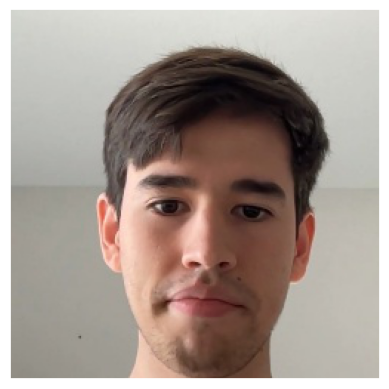

In [28]:
# For GOOGLE COLAB
test_image = image.load_img('/content/drive/MyDrive/Colab Notebooks/scikit_learn_data_test/lfw_home/lfw_funneled/Sergio_Cuenca/Sergio_Cuenca_00059.jpg')

# For OS
"""
test_image_dir = os.path.join(d, "data/test/scikit_learn_data_test/lfw_home/lfw_funneled/Sergio_Cuenca/Sergio_Cuenca_00059.jpg")
test_image = image.load_img(test_image_dir)
"""

plt.xticks([])
plt.yticks([])
plt.imshow(test_image)

In [29]:
x = image.img_to_array(test_image)
x = np.expand_dims(x, axis=0)

y = model.predict(x)[0]
for i in range(len(y)):
    print(data.target_names[i] + ': ' + str(y[i]))

1/1 [==============================] - 0s 198ms/step
People: 2.4166412e-28
Sergio Cuenca: 1.0


## Save model
Guardar y exportar el modelo en un archivo para poder utilizarlo más tarde.

In [30]:
from keras.models import load_model

# For GOOGLE COLAB
model_dir = "/content/drive/MyDrive/Colab Notebooks/cnn_model_4.h5"

# For OS
"""
d = os.path.dirname(os.getcwd())
model_dir = os.path.join(d, "models/cnn_model_4.h5")
"""

# Guarda el modelo en un archivo
model.save(model_dir)


In [31]:
imported_model = load_model(model_dir)

# For GOOGLE COLAB
test_image = image.load_img('/content/drive/MyDrive/Colab Notebooks/scikit_learn_data_test/lfw_home/lfw_funneled/Sergio_Cuenca/Sergio_Cuenca_00059.jpg')

# For OS
"""
test_image_dir = os.path.join(d, "data/test/scikit_learn_data_test/lfw_home/lfw_funneled/Sergio_Cuenca/Sergio_Cuenca_00059.jpg")
test_image = image.load_img(test_image_dir)
"""

x = image.img_to_array(test_image)
x = np.expand_dims(x, axis=0)
y = imported_model.predict(x)[0]

for i in range(len(y)):
    print(data.target_names[i] + ': ' + str(y[i]))

1/1 [==============================] - 2s 2s/step
People: 2.4166412e-28
Sergio Cuenca: 1.0
